In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
from sklearn.cluster import KMeans

# 1. FUNGSI KONVERSI & WAKTU KOMPUTASI

In [2]:
def convert_colors(image):
    times = {}
    
    start = time.time()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    times['Gray'] = (time.time() - start) * 1000 # dalam ms
    
    start = time.time()
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    times['HSV'] = (time.time() - start) * 1000
    
    start = time.time()
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    times['LAB'] = (time.time() - start) * 1000
    
    return gray, hsv, lab, times

# 2. FUNGSI KUANTISASI

In [3]:
def uniform_quantization(image, levels=16):
    step = 256 // levels
    quantized = (image // step) * step
    return quantized.astype(np.uint8)

def nonuniform_quantization(image, n_clusters=16):
    # Menggunakan K-Means untuk clustering warna (non-uniform)
    h, w = image.shape[:2]
    if len(image.shape) == 3:
        pixels = image.reshape(-1, 3)
    else:
        pixels = image.reshape(-1, 1)
        
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pixels)
    centers = kmeans.cluster_centers_.astype(np.uint8)
    
    quantized = centers[labels].reshape(image.shape)
    return quantized

# 3. FUNGSI ANALISIS MEMORI

In [4]:
def calculate_memory(original_img, quantized_img, levels=16):
    # Asumsi: original 8-bit per channel. Kuantisasi 16 level = 4-bit.
    mem_original = original_img.size * original_img.itemsize # Bytes
    
    # Secara teknis di Python tipe datanya tetap uint8 (1 byte), 
    # tapi secara teoretis ukurannya bisa dipadatkan jadi 4-bit (0.5 byte)
    mem_quantized_theory = (quantized_img.size * 0.5) 
    
    compression_ratio = mem_original / mem_quantized_theory
    return mem_original, mem_quantized_theory, compression_ratio

# ------------------------------ MAIN PROGRAM ------------------------------

=== MEMULAI ANALISIS ===

Waktu Komputasi Konversi (ms):
- RGB ke Gray: 8.5356 ms
- RGB ke HSV: 4.9992 ms
- RGB ke LAB: 71.2194 ms

Analisis Memori (Kuantisasi 256 ke 16 level):
- Ukuran sebelum (bytes): 11808768
- Ukuran sesudah teoretis (bytes): 5904384.0
- Rasio Kompresi: 2.00x


C:\Users\aa870\AppData\Local\Temp\ipykernel_29124\1526391202.py:44: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  axes[1,0].hist(v.ravel(), 256, [0,256]); axes[1,0].set_title("Histogram Asli")
C:\Users\aa870\AppData\Local\Temp\ipykernel_29124\1526391202.py:45: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  axes[1,1].hist(v_uniform.ravel(), 256, [0,256]); axes[1,1].set_title("Histogram Uniform")
C:\Users\aa870\AppData\Local\Temp\ipykernel_29124\1526391202.py:46: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  axes[1,2].hist(v_nonuniform.ravel(), 256, [0,256]); axes[1,2].set_title("Histogram Non-Uniform")


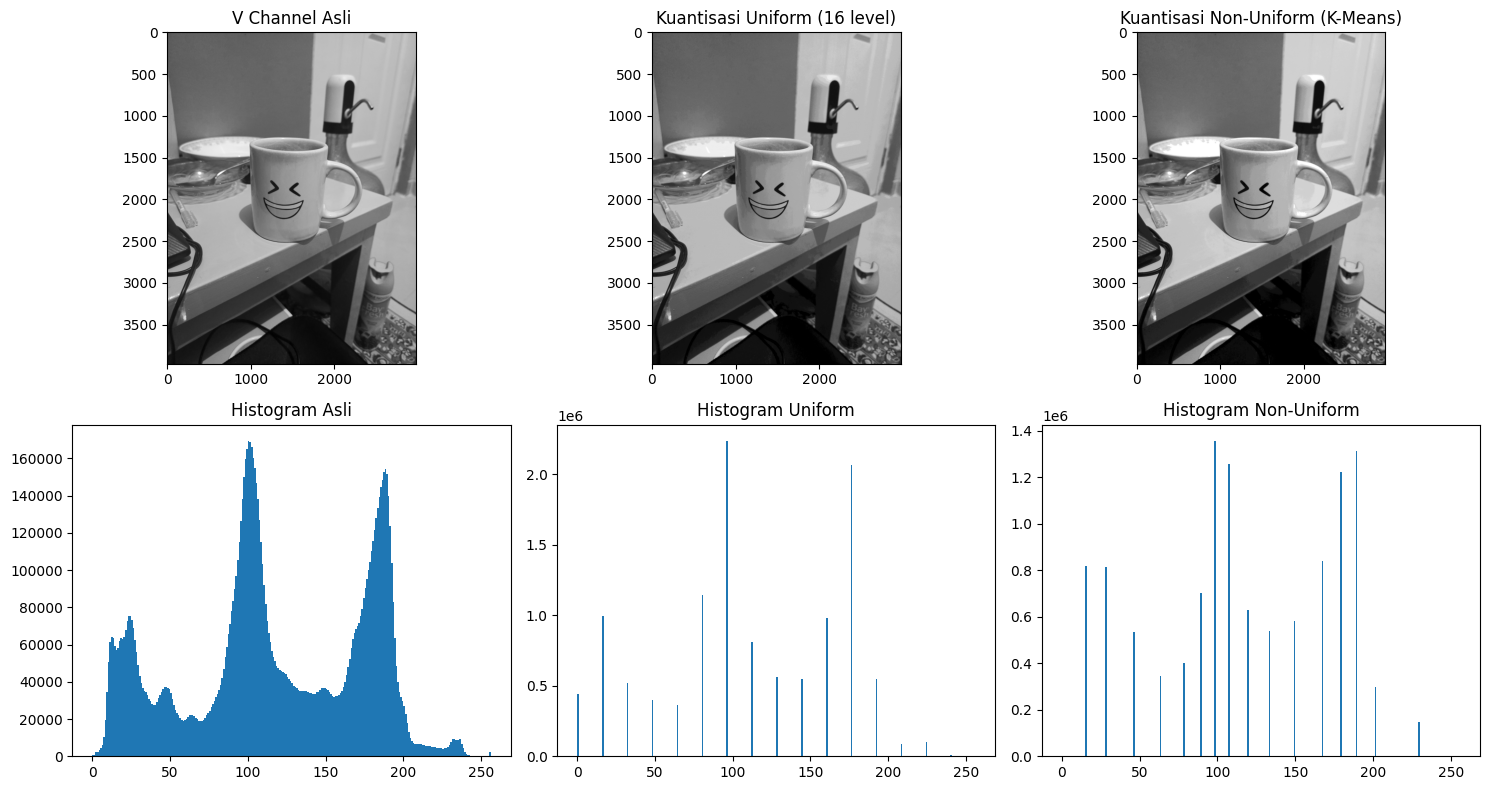

In [5]:
# Masukkan path gambar Anda di sini. 
# Jika belum ada, program ini akan error. Pastikan file tersedia!
image_paths = ['terang.jpg', 'normal.jpg', 'redup.jpg'] 
images = []

print("=== MEMULAI ANALISIS ===")
for path in image_paths:
    img = cv2.imread(path)
    if img is not None:
        images.append(img)
    else:
        print(f"Peringatan: {path} tidak ditemukan. Buat citra dummy untuk testing.")
        dummy = np.random.randint(0, 255, (200, 200, 3), dtype=np.uint8)
        images.append(dummy)

# Analisis untuk gambar pertama (Normal) sebagai representasi detail
test_img = images[1] 

# Konversi
gray, hsv, lab, conv_times = convert_colors(test_img)
print("\nWaktu Komputasi Konversi (ms):")
for space, t in conv_times.items():
    print(f"- RGB ke {space}: {t:.4f} ms")

# Kuantisasi pada HSV (menggunakan Value channel untuk contoh)
h, s, v = cv2.split(hsv)
v_uniform = uniform_quantization(v, 16)
v_nonuniform = nonuniform_quantization(v, 16)

# Parameter Memori
mem_ori, mem_quant, cr = calculate_memory(v, v_uniform, 16)
print("\nAnalisis Memori (Kuantisasi 256 ke 16 level):")
print(f"- Ukuran sebelum (bytes): {mem_ori}")
print(f"- Ukuran sesudah teoretis (bytes): {mem_quant}")
print(f"- Rasio Kompresi: {cr:.2f}x")

# Visualisasi
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes[0,0].imshow(v, cmap='gray'); axes[0,0].set_title("V Channel Asli")
axes[0,1].imshow(v_uniform, cmap='gray'); axes[0,1].set_title("Kuantisasi Uniform (16 level)")
axes[0,2].imshow(v_nonuniform, cmap='gray'); axes[0,2].set_title("Kuantisasi Non-Uniform (K-Means)")

# Histogram
axes[1,0].hist(v.ravel(), 256, [0,256]); axes[1,0].set_title("Histogram Asli")
axes[1,1].hist(v_uniform.ravel(), 256, [0,256]); axes[1,1].set_title("Histogram Uniform")
axes[1,2].hist(v_nonuniform.ravel(), 256, [0,256]); axes[1,2].set_title("Histogram Non-Uniform")

plt.tight_layout()
plt.show()